#### CS351 Term Project
- Mohsin Zia - 2020244
- Muhammad Abdullah - 2020256
- Irtaza Haider - 2020474

In [1]:
# Required Libraries

import matplotlib.pyplot as plt
import numpy as np
import cv2         
import os
import tifffile    
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import Conv2D
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from keras.models import Model
from tensorflow.keras.layers import Flatten
from keras.models import load_model
from tensorflow import keras

In [2]:
# Specifying the CAVE dataset path

directory = "./complete_ms_data"
path = os.listdir(directory)

In [3]:
# Dictionary in which we store the images path in this format [foldername: ./complete_ms_data/.......]

img_directory = {}
folder = []
#using os.walk
for root, dirs, folder in os.walk(directory):         
    dir_name = os.path.basename(root)
    img_directory[dir_name] = [root + '/' + file for file in folder]

key = list(img_directory.keys())[0]
img_directory.pop(key)

for key, value in img_directory.items():
    img_directory[key] = [v for v in value if "png" in v] 

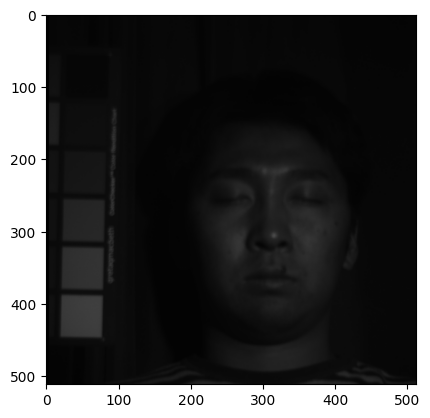

In [4]:
# Printing a sample image

img = cv2.imread(img_directory["face_ms"][0])
img.shape
plt.imshow(img)

In [5]:
# Let's stack all the bands

MultiSpectralImages = {}
count = 1

print("\nSubDirectories\n")

for img_name, direct in img_directory.items():
    images = [cv2.imread(img, 0) for img in direct]
    images = np.asarray(images)
    stacked_image = np.stack(images, axis=2)
    MultiSpectralImages[img_name] = stacked_image
    print(f"{count}) {img_name}")
    count = count + 1


SubDirectories

1) balloons_ms
2) beads_ms
3) cd_ms
4) chart_and_stuffed_toy_ms
5) clay_ms
6) cloth_ms
7) egyptian_statue_ms
8) face_ms
9) fake_and_real_beers_ms
10) fake_and_real_food_ms
11) fake_and_real_lemons_ms
12) fake_and_real_lemon_slices_ms
13) fake_and_real_peppers_ms
14) fake_and_real_strawberries_ms
15) fake_and_real_sushi_ms
16) fake_and_real_tomatoes_ms
17) feathers_ms
18) flowers_ms
19) glass_tiles_ms
20) hairs_ms
21) jelly_beans_ms
22) oil_painting_ms
23) paints_ms
24) photo_and_face_ms
25) pompoms_ms
26) real_and_fake_apples_ms
27) real_and_fake_peppers_ms
28) sponges_ms
29) stuffed_toys_ms
30) superballs_ms
31) thread_spools_ms
32) watercolors_ms


In [6]:
# Cropping the MultiSpectralImage from (512x512x31 to 64x64x31)

def CropMSI(MultiSpectralImages, dimension_1, dimension_2, dimension_3):
    
    croppedPatches = []

    for key, value in MultiSpectralImages.items():
        img_shape = MultiSpectralImages[key].shape
        width, height = img_shape[1], img_shape[0]

        for row in range(8):
            for col in range(8):

                img_patch = value[row*dimension_1:(row+1)*dimension_1, col*dimension_1:(col+1)*dimension_1, 0:dimension_3]                   
                croppedPatches.append(img_patch)

    return croppedPatches

In [7]:
# Crop all the bands to obtain multiple hyperspectral images of resolution 64x64x31

croppedPatches = CropMSI(MultiSpectralImages,64,64,31)
print("Length of cropped patches =",len(croppedPatches))

Length of cropped patches = 2048


In [8]:
#  Convert each image to the resolution of 64x64x31 and save it in numpy array

y = np.asarray(croppedPatches)
y = y.astype(float)
print("Label y =",y.shape)

Label y = (2048, 64, 64, 31)


#### Feature x1 = Typecasted from (64x64x31) to (8, 8, 31) ->  LowResHSI  (hxwxD)

In [9]:
x1 = tf.keras.layers.AveragePooling2D(pool_size=(8, 8),strides=(8, 8), padding='valid',dtype='float64')
x1 = x1(y)
print("x1 =",x1.shape)

x1 = (2048, 8, 8, 31)


#### Feature x2 = Typecasted from (64x64x31) to (64, 64, 3) -> HiResRGB (HxWxd) 

In [10]:
# Filter 1 (For first 10)
x2_1 = y[:,:,:,0:11].mean(axis = 3)

# Filter 2 (For 10-20)
x2_2 = y[:,:,:,10:21].mean(axis = 3)

# Filter 3 (For remaining 11)
x2_3 = y[:,:,:,20:].mean(axis = 3)
print("\nx2(1) =",x2_1.shape,"\nx2(2) =", x2_2.shape,"\nx2(3) =", x2_3.shape)

x2 = np.stack([x2_1, x2_2, x2_3], axis=3)                  
print('\nx2 stacked =', x2.shape)


x2(1) = (2048, 64, 64) 
x2(2) = (2048, 64, 64) 
x2(3) = (2048, 64, 64)

x2 stacked = (2048, 64, 64, 3)


In [11]:
# Printing the Ground Truth and Input Features shape

print("\nGround Truth = ", y.shape)
print("Feature x1 =   ",x1.shape)
print("Feature x2 =   ",x2.shape)
print("\n")



Ground Truth =  (2048, 64, 64, 31)
Feature x1 =    (2048, 8, 8, 31)
Feature x2 =    (2048, 64, 64, 3)




In [12]:
# Converting inputs and ground truth to numpy array as tensor flow need np array for computation

x1 = np.array(x1)
x2 = np.array(x2)
GroundTruth = np.array(y)

In [13]:
# Scaling the data between 0 and 1. Bringing them to same scale

x1 = x1/255.0
x2 = x2/255.0              
GroundTruth = GroundTruth/255.0

In [14]:
# Printing the Ground Truth and Input Features shape of np array

print("\nGround Truth = ", GroundTruth.shape)
print("Feature x1 =   ",x1.shape)
print("Feature x2 =   ",x2.shape)
print("\n")



Ground Truth =  (2048, 64, 64, 31)
Feature x1 =    (2048, 8, 8, 31)
Feature x2 =    (2048, 64, 64, 3)




### Until now we have only generated the data (x1, x2, y)

In [15]:
# Splitting the data to 80% train and 20% test to test our model on data that model has never seen

X_train_1, X_test_1, X_train_2, X_test_2, y_train, y_test = train_test_split(x1, x2, GroundTruth, test_size=0.20)

In [16]:
# Data after train-test-split

print("\nDatset shapes after splitting the data into train and test set")
print("\nX_train_1 shape:", X_train_1.shape)
print("X_test_1 shape:", X_test_1.shape)
print("X_train_2 shape:", X_train_2.shape)
print("X_test_2 shape:", X_test_2.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


Datset shapes after splitting the data into train and test set

X_train_1 shape: (1638, 8, 8, 31)
X_test_1 shape: (410, 8, 8, 31)
X_train_2 shape: (1638, 64, 64, 3)
X_test_2 shape: (410, 64, 64, 3)
y_train shape: (1638, 64, 64, 31)
y_test shape: (410, 64, 64, 31)


#### Required functions for the model to produce high resolution image

In [17]:
# PhaseDNN is able to convert high frequency learning to low frequency learning, allowing a uniform learning of wideband functions. 
# This function takes an input tensor I and rearranges its dimensions in a phase-dependent manner by
# splitting the width and height dimensions into smaller regions and then concatenating them back. The 
# resulting tensor has an increased spatial resolution (r times larger) in both width and height dimensions.

def phaseDNN(I, r):
    bsize, w, h, c = I.get_shape().as_list()
    bsize = tf.shape(I)[0]
    X = tf.reshape(I, (bsize, w, h, r, r))
    X = tf.split(X, w, 1)
    X = tf.concat([tf.squeeze(x, axis=1) for x in X], 2)
    X = tf.split(X, h, 1)
    X = tf.concat([tf.squeeze(x, axis=1) for x in X], 2)

    return tf.reshape(X, (bsize, w * r, h * r, 1))


# PixelShuffle aims is to produce a high-resolution image from a single low-resolution one.
# The PixelShuffle function takes an input tensor X and performs a pixel shuffling operation 
# by splitting the tensor along the channel dimension, applying the phaseDNN function to each split, 
# and then concatenating the results to obtain the final output tensor. The purpose of this operation 
# is typically to increase the spatial resolution of the input tensor.

def PixelShuffle(X, r):
    Xc = tf.split(X, 31, 3)
    X = tf.concat([phaseDNN(x, r) for x in Xc], 3)
    return X



### Convolution Neural Network Architecture

In [18]:
# The model takes a multispectral image and an RGB image as inputs and performs a series of convolutional operations, 
# attention mechanisms, and skip connections to reconstruct a high-resolution multispectral image. The spatial 
# attention maps guide the model to focus on relevant information, and the ResNet blocks help capture and preserve 
# fine details during the reconstruction process.

totalBands = 31 
resnetLayerBlocks = 6
numberOfFilters = 64
# Weight decay is a regularization method to make models generalize better by learning smoother functions.
weight_decay = 1e-4



# For LowResHSI
ms = tf.keras.Input(shape=(8, 8, 31))
# For HiResRGB
RGB = tf.keras.Input(shape=(64, 64, 3))

# Layer 1
ms_copy = tf.keras.layers.Conv2D(totalBands * 8 * 8, kernel_size=1, strides=1, activation=tf.nn.leaky_relu,
                            kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
                            kernel_initializer=tf.keras.initializers.VarianceScaling(),
                            padding='same')(ms)

# Produce high resolution image.
ms_copy = PixelShuffle(ms_copy, 8)



gap_ms_c = tf.reduce_mean(ms, axis=[1, 2], keepdims=True)
# Layer 2
CA = tf.keras.layers.Conv2D(1, kernel_size=1, strides=1, activation=tf.nn.leaky_relu,
                            kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
                            kernel_initializer=tf.keras.initializers.VarianceScaling())(gap_ms_c)



# Layer 3
CA = tf.keras.layers.Conv2D(totalBands, kernel_size=1, strides=1, activation=tf.nn.sigmoid,
                            kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
                            kernel_initializer=tf.random_normal_initializer())(CA)




# Spatial Attention
gap_RGB_s = tf.reduce_mean(RGB, axis=3, keepdims=True)
# Layer 4
SA = tf.keras.layers.Conv2D(1, kernel_size=6, strides=1, activation=tf.nn.sigmoid,
                            kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
                            kernel_initializer=tf.keras.initializers.VarianceScaling(),
                            padding='same')(gap_RGB_s)



# Downsampled RGB
# Layer 5
rgb = tf.keras.layers.Conv2D(3, kernel_size=10, strides=7, activation=None,
                              kernel_initializer=tf.keras.initializers.VarianceScaling(),
                              kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(RGB)
rslice, gslice, bslice = tf.split(rgb, 3, axis=3)
msp1, msp2 = tf.split(ms, [15, 16], axis=3)
ms_new = tf.concat([rslice, msp1, gslice, msp2, bslice], axis=3)


# Layer 6
rs = tf.keras.layers.Conv2D(totalBands * 8 * 8, kernel_size=3, strides=1, activation=tf.nn.leaky_relu,
                            kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
                            kernel_initializer=tf.keras.initializers.VarianceScaling(),
                            padding='same')(ms_new)
# Produce high resolution image.
rs = PixelShuffle(rs, 8)
Rslice, Gslice, Bslice = tf.split(RGB, 3, axis=3)
Msp1, Msp2 = tf.split(rs, [15, 16], axis=3)



rs = tf.concat([Rslice, Msp1, Gslice, Msp2, Bslice], axis=3)
# Layer 7
rs = tf.keras.layers.Conv2D(numberOfFilters, kernel_size=3, strides=1, activation=tf.nn.leaky_relu,
                            kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
                            kernel_initializer=tf.keras.initializers.VarianceScaling(),
                            padding='same')(rs)



# ResNet Blocks
# ResNetLayers deployed.
for _ in range(resnetLayerBlocks):
    rs1 = tf.keras.layers.Conv2D(numberOfFilters, kernel_size=3, strides=1, activation=tf.nn.leaky_relu,
                                  kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
                                  kernel_initializer=tf.keras.initializers.VarianceScaling(),
                                 padding='same')(rs)
    rs1 = tf.keras.layers.Conv2D(numberOfFilters, kernel_size=3, strides=1, activation=None,
                                  kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
                                  kernel_initializer=tf.keras.initializers.VarianceScaling(),
                                 padding='same')(rs1)
    rs = tf.add(rs, rs1)




rs = SA * rs
# Final hidden layer
rs = tf.keras.layers.Conv2D(totalBands, kernel_size=3, strides=1, activation=None,
                            kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
                            kernel_initializer=tf.keras.initializers.VarianceScaling(),
                            padding='same')(rs)
rs = CA * rs

reconstructed_ms = tf.keras.layers.Add()([rs, ms_copy])


# Inputs are multispectral image and RGB image.
inputs = [ms, RGB]
outputs = reconstructed_ms
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [19]:
# Compiling the model

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['accuracy'])

In [20]:
# Train the model on training set and validate on test set.

history = model.fit(x=[X_train_1, X_train_2], y=y_train, epochs=30, batch_size=32, validation_data=([X_test_1, X_test_2], y_test))

Epoch 1/30
52/52 [==============================] - 124s 2s/step - loss: 0.3676 - accuracy: 0.1696 - val_loss: 0.2470 - val_accuracy: 0.2527
Epoch 2/30
52/52 [==============================] - 97s 2s/step - loss: 0.1849 - accuracy: 0.3251 - val_loss: 0.1355 - val_accuracy: 0.3492
Epoch 3/30
52/52 [==============================] - 95s 2s/step - loss: 0.1067 - accuracy: 0.4208 - val_loss: 0.0826 - val_accuracy: 0.4249
Epoch 4/30
52/52 [==============================] - 94s 2s/step - loss: 0.0666 - accuracy: 0.4897 - val_loss: 0.0523 - val_accuracy: 0.4818
Epoch 5/30
52/52 [==============================] - 95s 2s/step - loss: 0.0426 - accuracy: 0.5345 - val_loss: 0.0350 - val_accuracy: 0.5250
Epoch 6/30
52/52 [==============================] - 95s 2s/step - loss: 0.0289 - accuracy: 0.5269 - val_loss: 0.0227 - val_accuracy: 0.5340
Epoch 7/30
52/52 [==============================] - 94s 2s/step - loss: 0.0186 - accuracy: 0.5728 - val_loss: 0.0154 - val_accuracy: 0.5557
Epoch 8/30
52/52 [=

In [21]:
# Evaluating the performace of our CNN model on the training set and test set.

loss, acc = model.evaluate(x=[X_train_1, X_train_2], y=y_train, batch_size=32, verbose=0)
print(f'Accuracy on train set: {acc*100:.3f} % ')
loss, acc = model.evaluate(x=[X_test_1, X_test_2], y=y_test, batch_size=32, verbose=0)
print(f'Accuracy on test set: {acc*100:.3f} % ')


Accuracy on train set: 61.874 % 
Accuracy on test set: 60.420 % 


In [22]:
# Saving the model so that we don't have to train on CNN again.

model.save('./2020244_2020256_2020474.h5')

In [23]:
# Predicting the model on x1 and x2 features.

y_hat = model.predict([x1, x2])
y_hat.shape

64/64 [==============================] - 31s 466ms/step


(2048, 64, 64, 31)

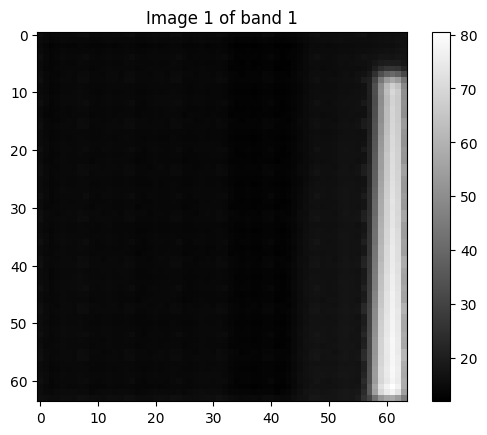

In [24]:
# Multiplying the image with 255 as we divided it for normalization

y_hat = y_hat * 255

# Plotting the 0th image predicted from band 0.

band_index = 0
band = y_hat[1,:, :, band_index]

# Plot the image
plt.imshow(band, cmap='gray')  # Use 'gray' colormap for grayscale images
plt.title("Image 1 of band 1")
plt.colorbar()
plt.show()

#### Predicted Images Visualization with high (spatial) resolution and high spectral resolution HiResSHI image (64x64x31).


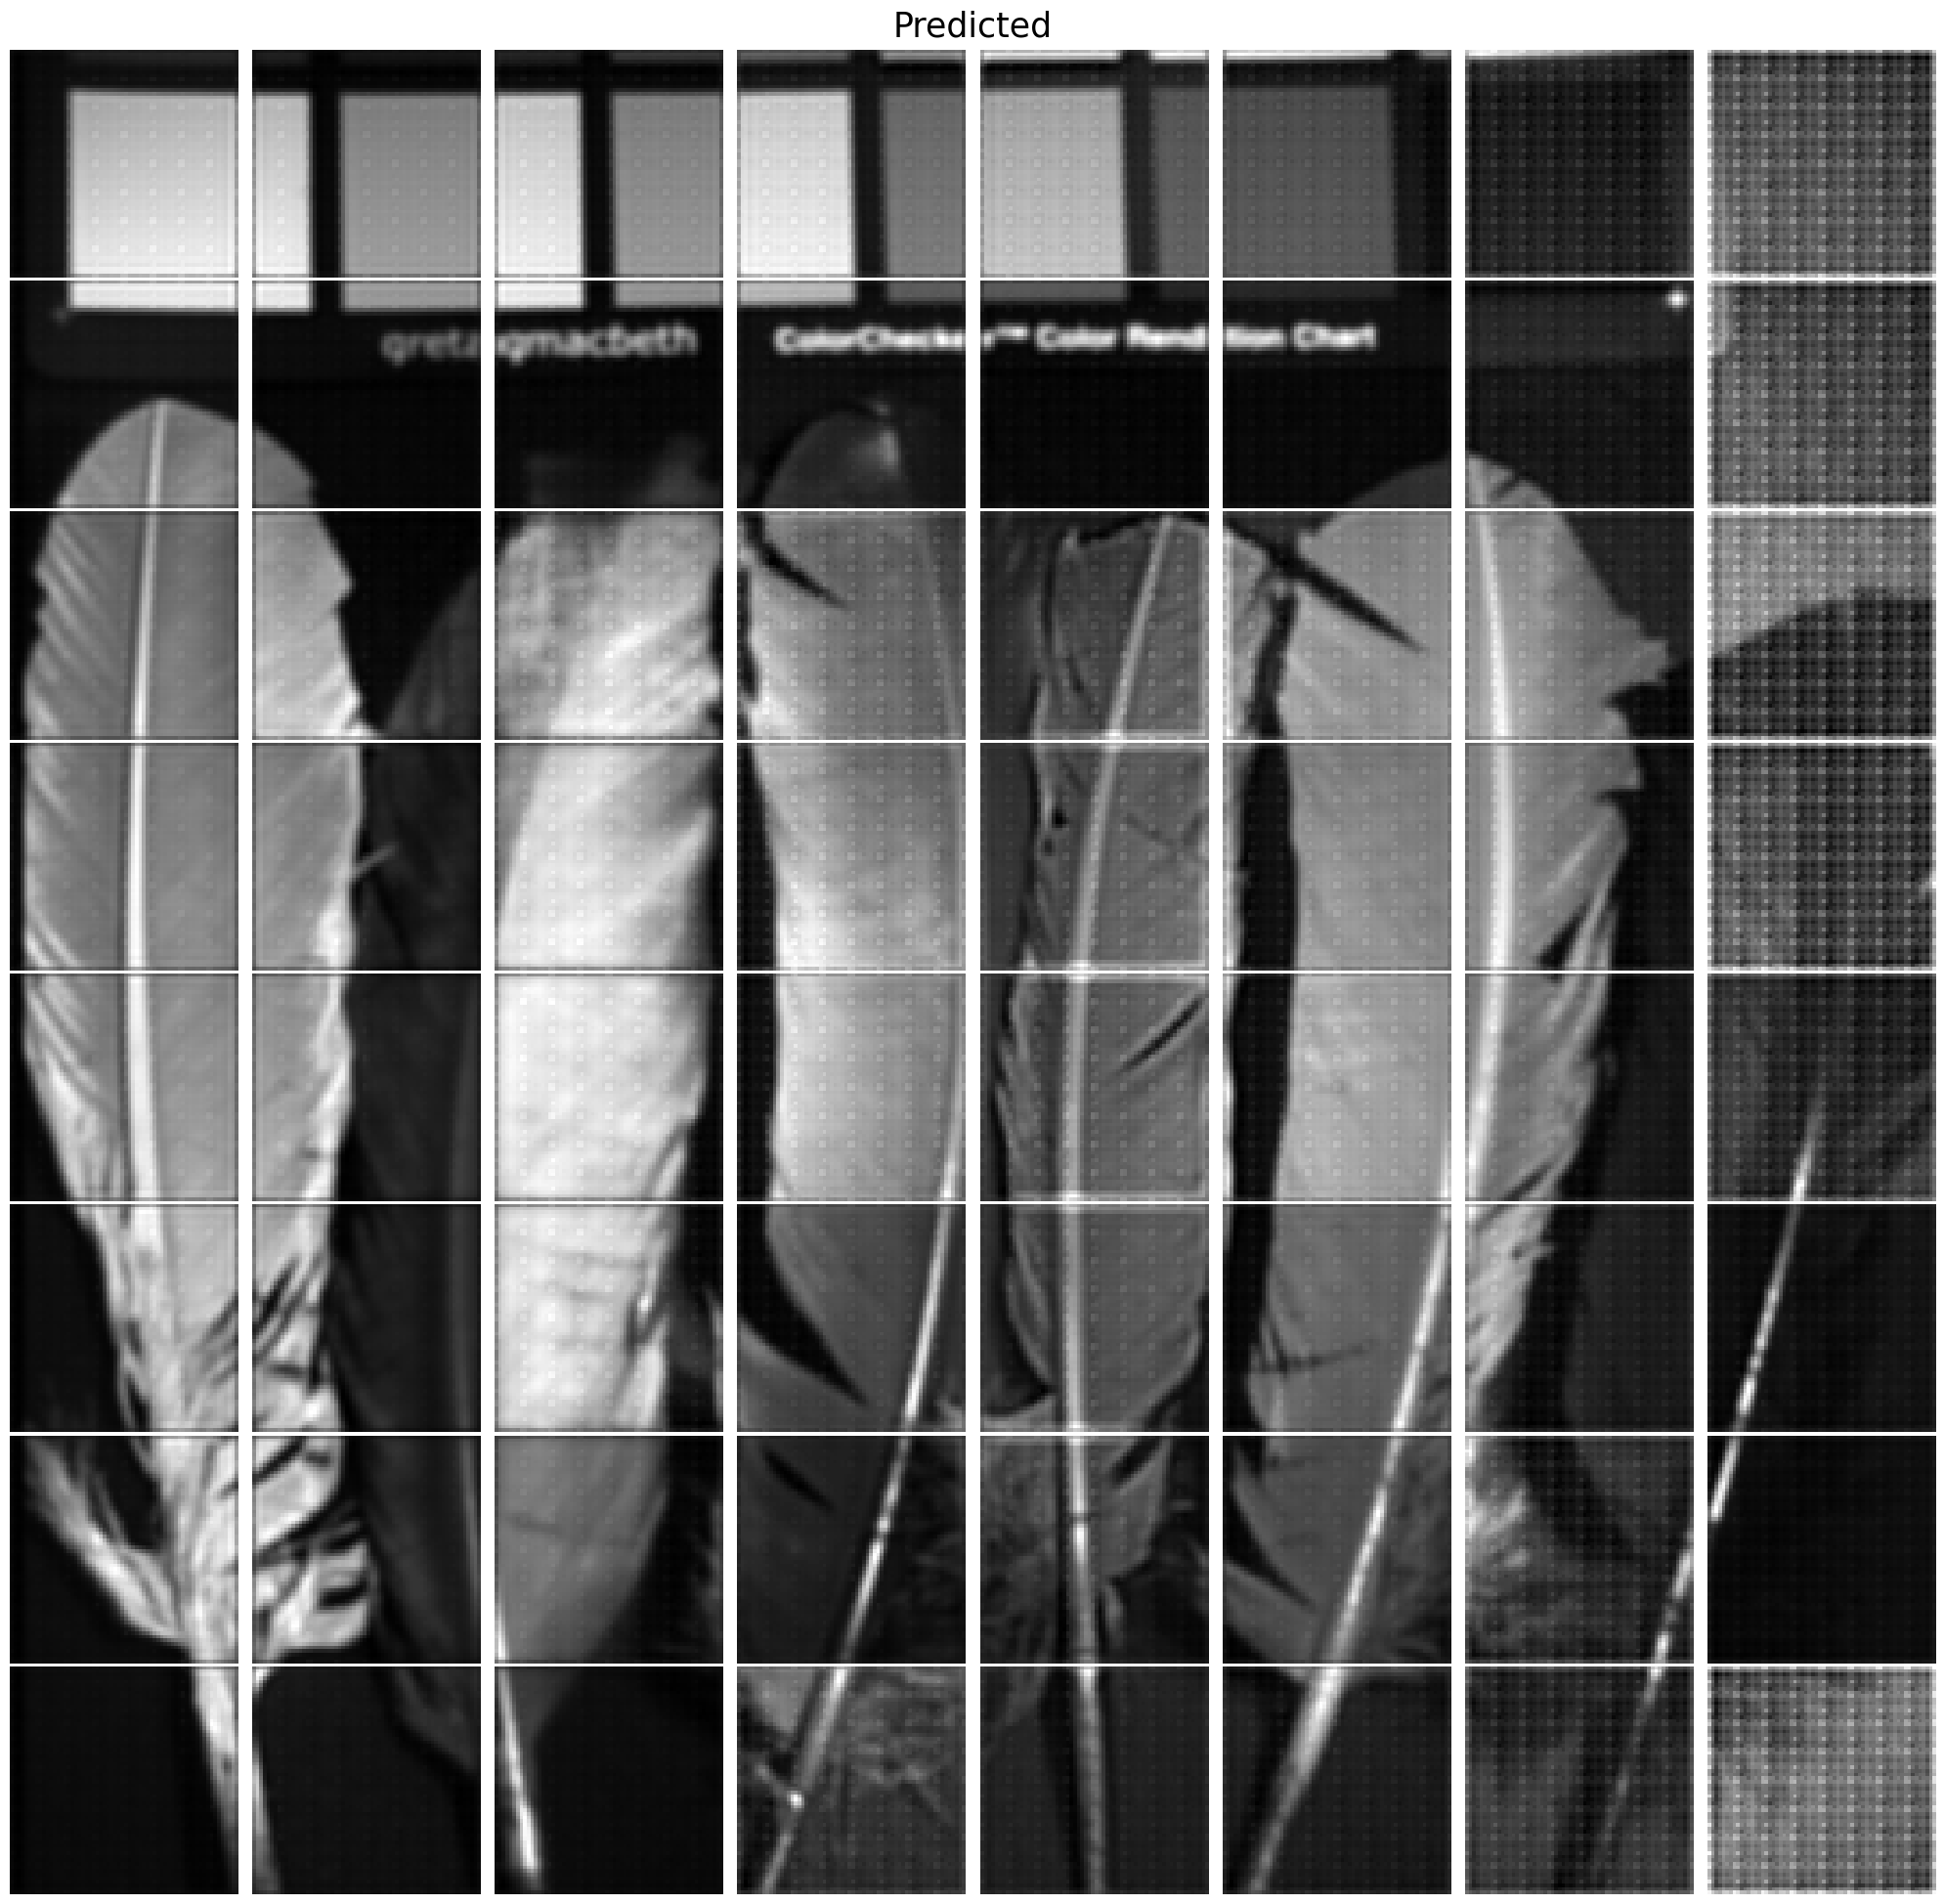

In [25]:
# Creating a subplots for printing first 64 images of 1st band which are predicted by model.

# Convert back data as we have normalized it before.
y_hat = y_hat * 255

fig, axs = plt.subplots(8, 8, figsize=(20, 20))

axs = axs.flatten()
j = 1024
for i in range(64):
    axs[i].imshow(y_hat[j, :, :, band_index],cmap='gray')
    axs[i].axis('off')
    j = j+1

fig.suptitle("Predicted", fontsize = 25)
fig.subplots_adjust(top=1.1)

plt.tight_layout()
plt.show()

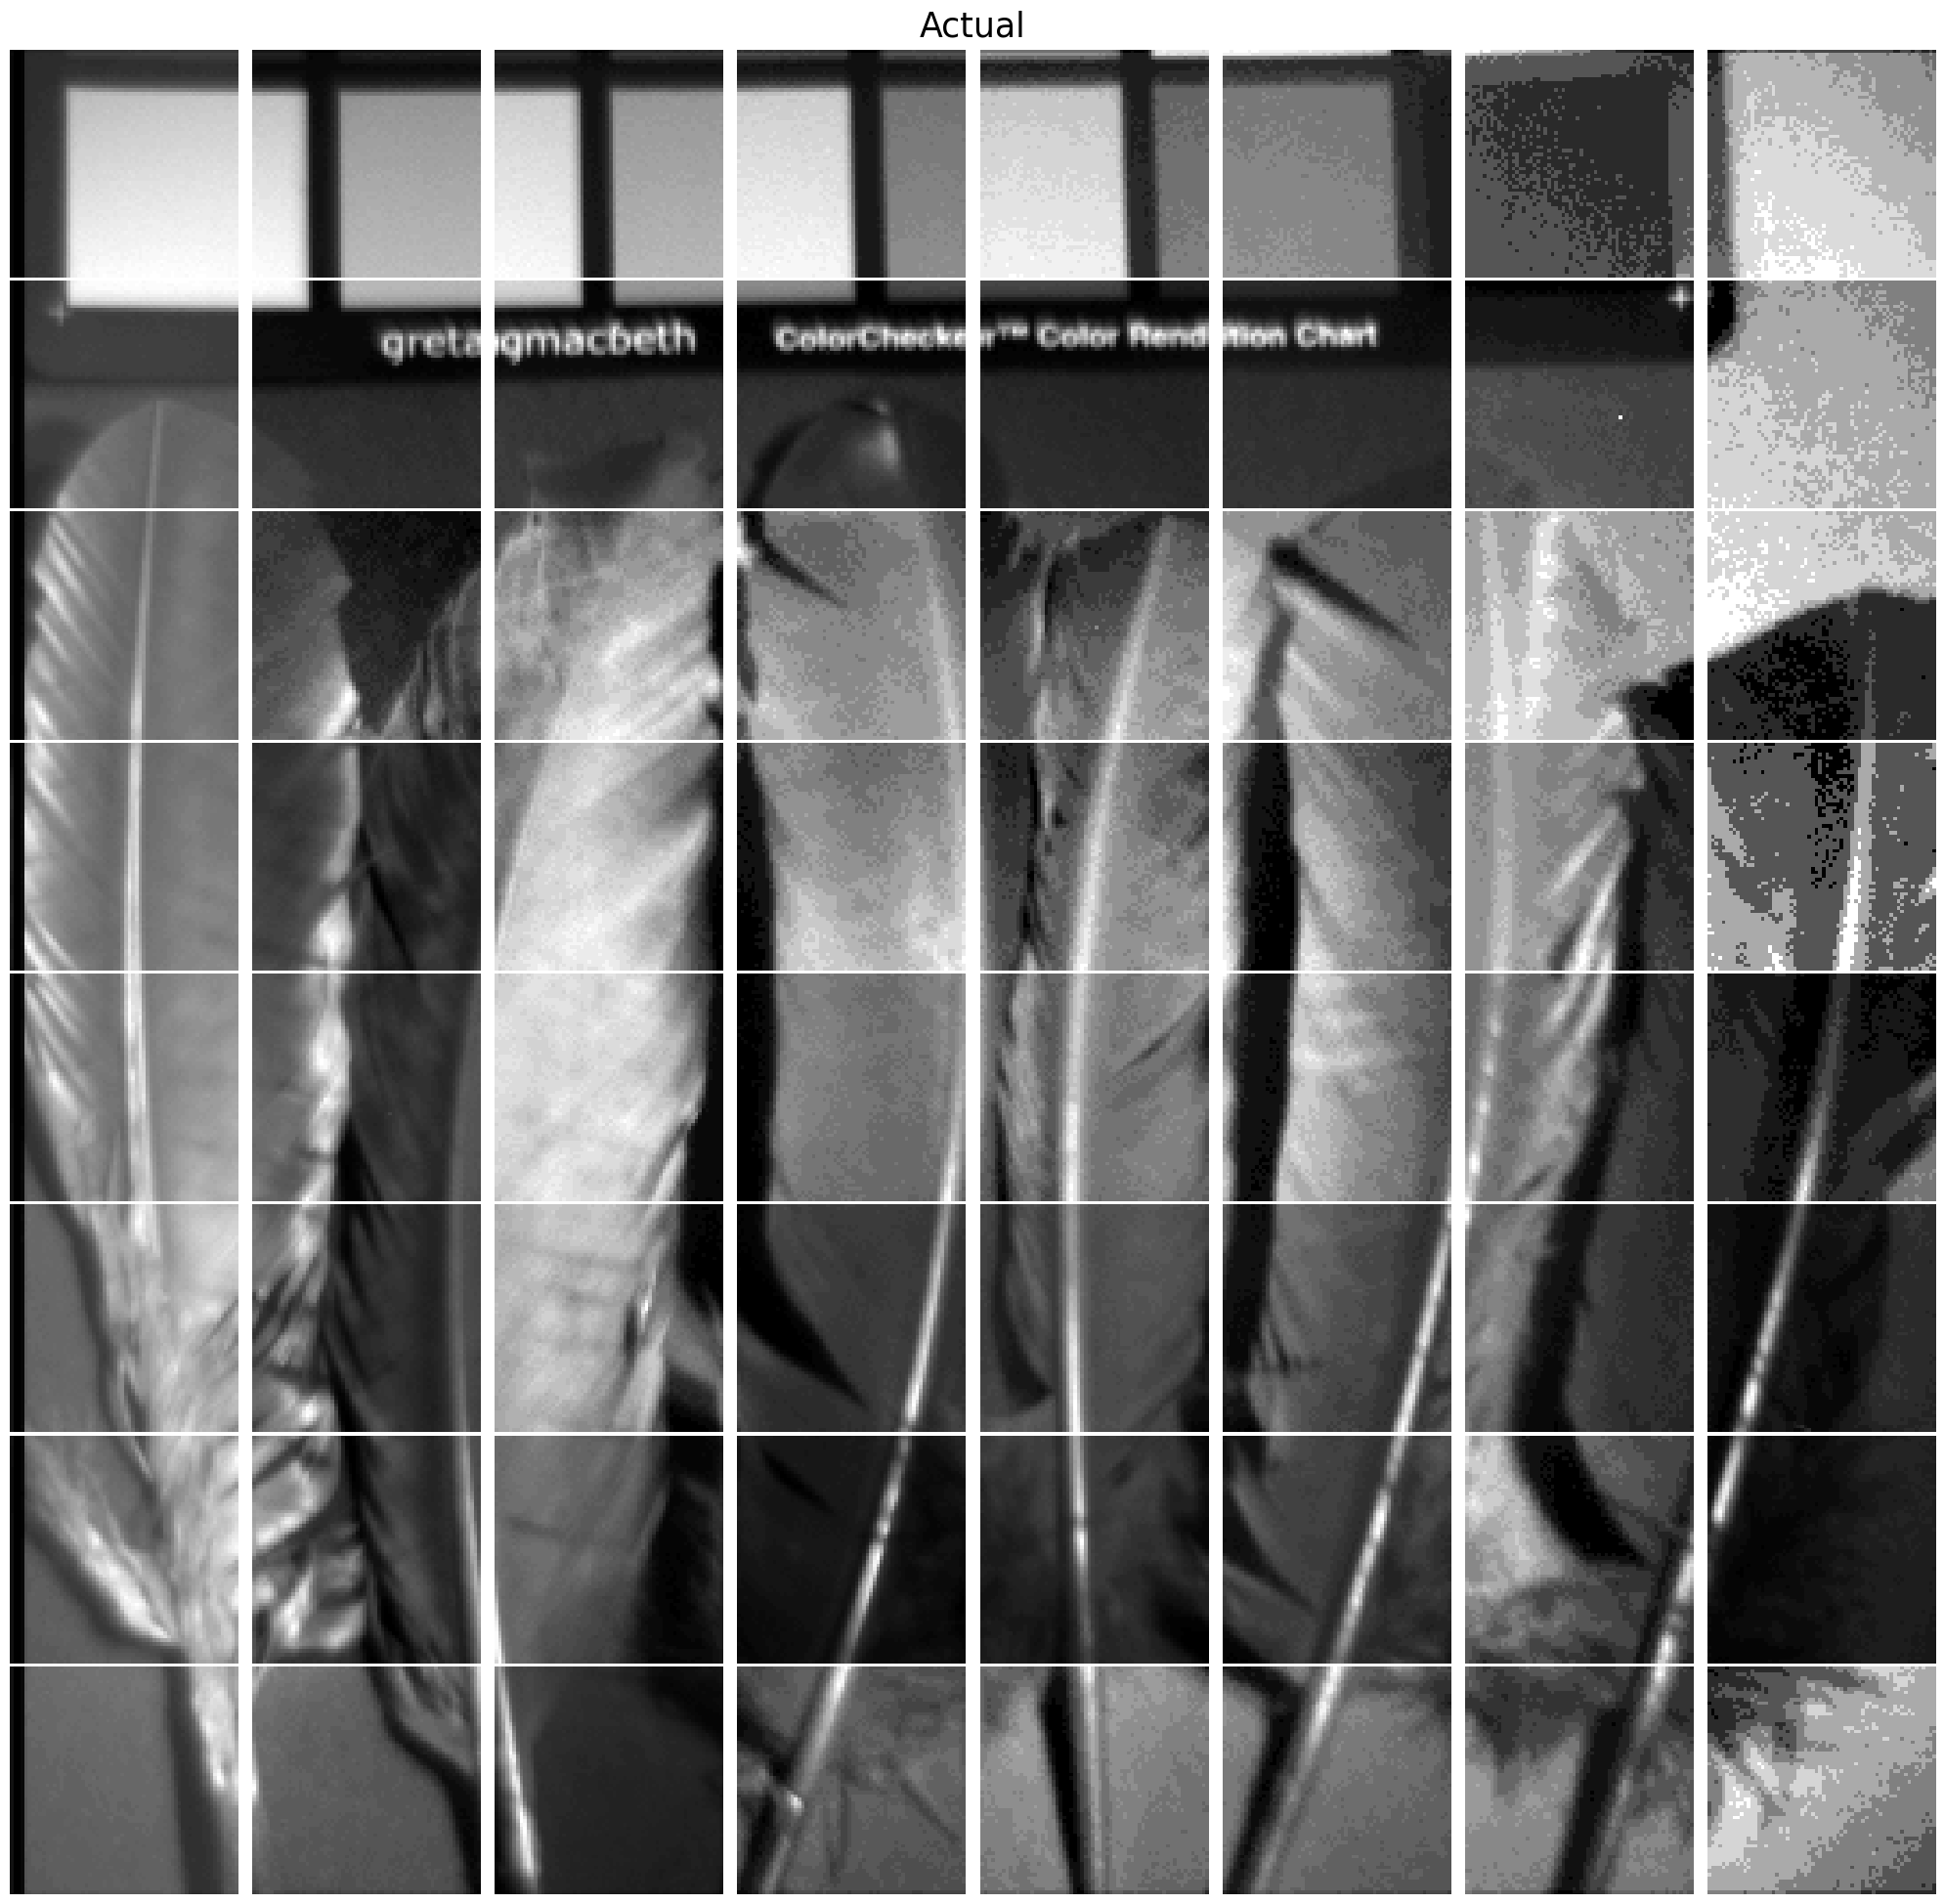

In [26]:
# Creating a subplots for printing first 64 images of 1st band that are actual images

# Convert back data as we have normalized it before.0
y = y * 255

fig, axs = plt.subplots(8, 8, figsize=(20, 20))
axs = axs.flatten()
j = 1024
for i in range(64):
    axs[i].imshow(y[j, :, :, band_index],cmap='gray')
    axs[i].axis('off')
    j = j+1

fig.suptitle("Actual", fontsize = 25)
fig.subplots_adjust(top=1.1)

plt.tight_layout()
plt.show()